In [1]:
import gzip
import numpy as np
import matplotlib.pyplot as plt


<H1> LOAD DATA 

Train data (X) size: (60000, 28, 28), and labels (Y) size: (60000,)
Test data (X) size: (10000, 28, 28), and labels (Y) size: (10000,)


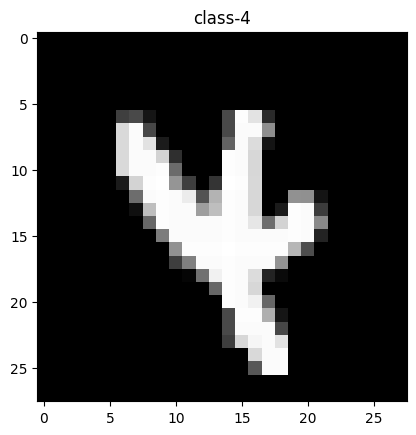

Train image 29340-th sample 
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  63  73  21   0   0   0   0   0  73 253 227  42
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 217 251  71   0   0   0   0   0  73 251 251 142
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 217 251 2

In [2]:
def read_images(filename):
    """Read MNIST images"""
    
    with gzip.open(filename, 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of images
        image_count = int.from_bytes(f.read(4), 'big')
        # third 4 bytes is the row count
        row_count = int.from_bytes(f.read(4), 'big')
        # fourth 4 bytes is the column count
        column_count = int.from_bytes(f.read(4), 'big')
        # rest is the image pixel data, each pixel is stored as an unsigned byte
        # pixel values are 0 to 255
        image_data = f.read()
        images = np.frombuffer(image_data, dtype=np.uint8).reshape((image_count, row_count, column_count))
        
    return images

def read_labels(filename):
    """Read MNIST labels"""
    
    with gzip.open(filename, 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of labels
        label_count = int.from_bytes(f.read(4), 'big')
        # rest is the label data, each label is stored as unsigned byte
        # label values are 0 to 9
        label_data = f.read()
        labels = np.frombuffer(label_data, dtype=np.uint8)
        
    return labels


dataset_path = './data/images/mnist/'# Change your data path

train_image_filename = ''.join([dataset_path, 'train-images-idx3-ubyte.gz'])
train_label_filename = ''.join([dataset_path, 'train-labels-idx1-ubyte.gz'])

test_image_filename = ''.join([dataset_path, 't10k-images-idx3-ubyte.gz'])
test_label_filename = ''.join([dataset_path, 't10k-labels-idx1-ubyte.gz'])

train_images = read_images(train_image_filename)
train_labels = read_labels(train_label_filename)
print('Train data (X) size: {}, and labels (Y) size: {}' .format(train_images.shape, train_labels.shape))

test_images = read_images(test_image_filename)
test_labels = read_labels(test_label_filename)
print('Test data (X) size: {}, and labels (Y) size: {}' .format(test_images.shape, test_labels.shape))

rand_ids = np.random.choice(train_images.shape[0])
plt.imshow(train_images[rand_ids, :, :], cmap='gray')
plt.title('class-'+str(train_labels[rand_ids]))
plt.show()

print('Train image {}-th sample ' .format(rand_ids))
print(train_images[rand_ids, :, :])



<h1> DISTANCE FUNCTION 

In [3]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

def pairwise_distances(X):
    n = X.shape[0]
    distances = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            distances[i, j] = euclidean_distance(X[i], X[j])
            distances[j, i] = distances[i, j]
    return distances

<h1> MDS 

In [4]:

def mds(distances, n_components=2):
    n = distances.shape[0]
    H = np.eye(n) - np.ones((n, n)) / n
    B = -0.5 * (H @ distances**2 @ H)
    eigenvalues, eigenvectors = np.linalg.eigh(B)
    
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    eigenvalues = eigenvalues[:n_components]
    eigenvectors = eigenvectors[:, :n_components]
    
    X_embedded = eigenvectors * np.sqrt(eigenvalues)
    
    return X_embedded

num_samples_per_class = 600
sampled_indices = []
for i in range(10):
    class_indices = np.where(train_labels == i)[0]
    sampled_indices.extend(np.random.choice(class_indices, num_samples_per_class, replace=False))

train_images_sampled = train_images[sampled_indices]
train_labels_sampled = train_labels[sampled_indices]

train_images_sampled_flat = train_images_sampled.reshape(train_images_sampled.shape[0], -1)

distance_matrix = pairwise_distances(train_images_sampled_flat)

X_2d = mds(distance_matrix)



<h1> Plotting

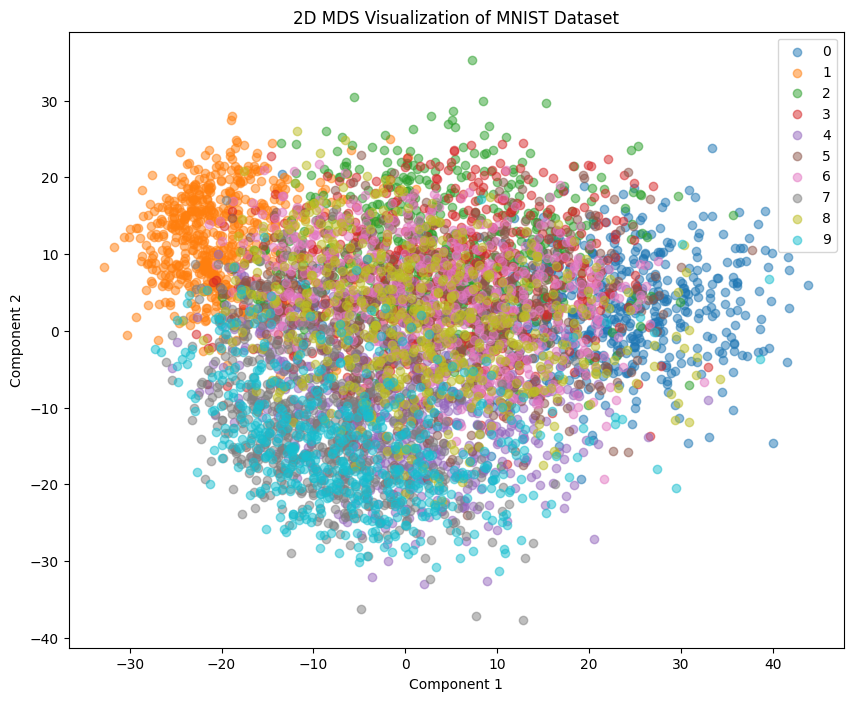

In [5]:
plt.figure(figsize=(10, 8))
for i in range(10):
    class_indices = np.where(train_labels_sampled == i)[0]
    plt.scatter(X_2d[class_indices, 0], X_2d[class_indices, 1], label=str(i), alpha=0.5)
plt.title('2D MDS Visualization of MNIST Dataset')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.show()